# Classification to identify tasks

This notebook reproduces plots that appear in Fig 4 of the paper:
- Gilson M, Zamora-López G, Pallarés V, Adhikari MH, Senden M, Tauste Campo A, Mantini D, Corbetta M, Deco G, Insabato A (submitted) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", bioRxiv; https://doi.org/10.1101/531830.

The goal of to compare the connectivity measures (in particular, effective versus functional connectivity) in identifying tasks performed by subjects in the scanner. The data comprise 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie M1-M2-M3). Two classifications are considered: rest versus movie, and rest/M1/M2/M3.

It uses the scikit-learn library, see https://scikit-learn.org/ for details and tutorials.

In [1]:
# Toggle to True to create directory and store results there
save_outputs = False
if save_outputs:
    import os
    res_dir = 'classif/'
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

We load the data and calculate the features: 'EC' stands for effective connectivity (estimated for the MOU model, see the *MOU_EC_Estimation* notebook), 'FC' for the BOLD correlations, 'FC+mask' for the BOLD correlations only concerning the ROI connections that exist according to the structural data (diffusion tensor imaging), 'PC' for the partial correlations.

In [2]:
# Import dependencies
import numpy as np
import scipy.stats as stt
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.metrics as skm
import matplotlib.pyplot as plt


In [3]:
# Set data parameters
param_dir = 'model_param_movie/'
n_sub = 22 # number of subjects
n_run = 5  # number of sessions per subject (2 rest + 3 movie)
N = 66     # number of ROIs

# Load data previously generated in notebook 'MOU_EC_Estimation.ipynb'
# Effective connectivity estimated using the MOU dynamic model
EC = np.load(param_dir + 'J_mod.npy')
# Mask of existing connections in SC (structural connectivity)
mask_EC = np.load(param_dir + 'mask_EC.npy')
# BOLD covariances (without time lag)
FC0 = np.load(param_dir + 'FC_emp.npy')[:,:,0,:,:]
# triangular mask to retain half of the matrix elemenets in symmetric matrices
mask_tri = np.tri(N,N,-1,dtype=np.bool)

# Calculate features
for i_sub in range(n_sub):
    for i_run in range(n_run):
        EC[i_sub,i_run,mask_EC] = stt.zscore(EC[i_sub,i_run,mask_EC]) # apply z-scoring to EC

corr = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        corr[i_sub,i_run,:,:] /= np.sqrt(np.outer(corr[i_sub,i_run,:,:].diagonal(),corr[i_sub,i_run,:,:].diagonal()))

PC = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        PC[i_sub,i_run,:,:] = -np.linalg.pinv(PC[i_sub,i_run,:,:])
        PC[i_sub,i_run,:,:] /= np.sqrt(np.outer(PC[i_sub,i_run,:,:].diagonal(),PC[i_sub,i_run,:,:].diagonal()))

# Plotting labels for connectivity measures
n_conn = 4
label_conn = ['EC', 'FC', 'FC+mask', 'PC']

The following code repeats the classification by splitting the fMRI sessions into a train set and test set (*n_rep* times). Here the 22 subjects are split in 80% for training and 20% for testing. We compare 3 classifiers:
- MLR is the multinomial logistic regression;
- 1NN is the 1-nearest-neighbor;
- LDA performs the linear discriminant analysis.

See the scikit-learn webpage for details.

In [4]:
# WARNING: Running this cell may take a few minutes
# Labels of sessions for classification
# distinct labels for movie runs
task4_labels = np.repeat(np.array([0,0,1,2,3],dtype=np.int).reshape([1,-1]), n_sub, axis=0)
# rest versus movie, same labels for movie runs
RM_labels = np.repeat(np.array([0,0,1,1,1],dtype=np.int).reshape([1,-1]), n_sub, axis=0) 

# number of repetitions and storage of results
n_rep = 40
perf = np.zeros([2,n_rep,n_conn,3])


# loop over classification type
for i_classif in range(2):

    if i_classif==0: # discriminate rest and 3 movie sessions individually
        lab_tmp = task4_labels
    else:            # discriminate rest vs movie
        lab_tmp = RM_labels

    # repeat classification
    for i_rep in range(n_rep):

        # split run indices in train and test sets (choose some subjects for train and rest for test)
        train_ind = np.ones([n_sub,n_run],dtype=bool)
        while train_ind[:,0].sum()>=0.8*n_sub:
            train_ind[np.random.randint(n_sub),:] = False
        test_ind = np.logical_not(train_ind)        
        
        # loop over connectivity measures
        for i_conn in range(n_conn):

            if i_conn==0:
                vect_features = EC[:,:,mask_EC]    # vectorized EC matrices (only retaining existing connections)
            elif i_conn==1:
                vect_features = corr[:,:,mask_tri] # vectorized FC matrices (only retaining low triangle)
            elif i_conn==2:
                vect_features = corr[:,:,mask_EC]  # vectorized FC matrices (only retaining SC existing connections)
            else:
                vect_features = PC[:,:,mask_tri]   # vectorized PCmatrices (only retaining low triangle)

            dim_feature = vect_features.shape[2]   # dimension of vectorized EC

            # number of components for LDA
            if i_classif==0:
                n_comp_LDA = 3
            else:
                n_comp_LDA = 1

            # classifier and learning parameters
            c_MLR = skppl.make_pipeline(skppc.StandardScaler(),skllm.LogisticRegression(C=0.1, penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=500))
            c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')
            c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA,solver='eigen',shrinkage='auto')
            
            # train and test classifiers with subject labels
            c_MLR.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,0] = c_MLR.score(vect_features[test_ind,:], lab_tmp[test_ind])
        
            c_1NN.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,1] = c_1NN.score(vect_features[test_ind,:], lab_tmp[test_ind])
        
            c_LDA.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,2] = c_LDA.score(vect_features[test_ind,:], lab_tmp[test_ind])

The performance is interpreted by comparing the classification accuracy with the chance level (the dashed line), in relation with the gap towards 100% correct. Here we can calculate the chance level straight from the session properties.

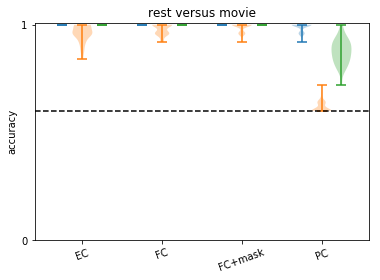

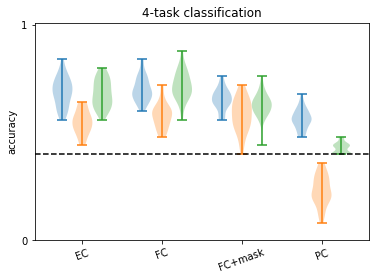

In [5]:
# plot rest versus movie
chance_level = 3. / n_run # chance level: predicting always movie gives 60% (as compared to predicting rest, 40%)

plt.figure()
plt.violinplot(perf[1,:,:,0], positions=np.arange(n_conn)-0.25, widths=[0.25]*n_conn)
plt.violinplot(perf[1,:,:,1], positions=np.arange(n_conn), widths=[0.25]*n_conn)
plt.violinplot(perf[1,:,:,2], positions=np.arange(n_conn)+0.25, widths=[0.25]*n_conn)
plt.plot([-1,n_conn], [chance_level]*2, '--k')
plt.axis(xmin=-0.6,xmax=n_conn-0.4,ymin=0,ymax=1.01)
plt.xticks(range(n_conn), ['EC','FC','FC+mask','PC'], rotation=20)
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.title('rest versus movie')


# plot 4 classes (rest, movie1, movie2, movie3)
chance_level = 2. / n_run # chance level: predicting always rest gives 40% (as compared to predicting a movie session, 20%)

plt.figure()
plt.violinplot(perf[0,:,:,0], positions=np.arange(n_conn)-0.25, widths=[0.25]*n_conn)
plt.violinplot(perf[0,:,:,1], positions=np.arange(n_conn), widths=[0.25]*n_conn)
plt.violinplot(perf[0,:,:,2], positions=np.arange(n_conn)+0.25, widths=[0.25]*n_conn)
plt.plot([-1,n_conn], [chance_level]*2, '--k')
plt.axis(xmin=-0.6,xmax=n_conn-0.4,ymin=0,ymax=1.01)
plt.xticks(range(n_conn), ['EC','FC','FC+mask','PC'], rotation=20)
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.title('4-task classification')

plt.show()

Confusion matrices are useful to understand the errors performed by the train classifier on the test set. Each row represents the classification of a test sample, with the diagonal element corresponding to the correct classification and off-diagonal elements to errors. Here we separate the 5 sessions to show that the two rest sessions are not separable by the MRL.

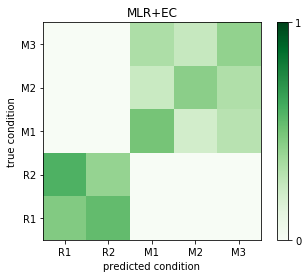

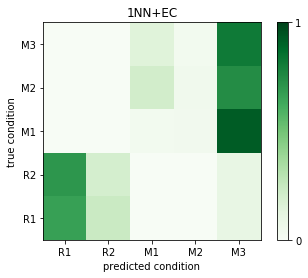

In [6]:
# use vectorized EC as features
vect_features = EC[:,:,mask_EC]
                   
# individual labels for each session for classification (separating the 2 rest sessions)
run5_labels = np.repeat(np.array([0,1,2,3,4],dtype=np.int).reshape([1,-1]), n_sub, axis=0) # distinct labels for each run/session

# confusion matrices (1 dimension per condition)
conf_mat_MLR = np.zeros([n_rep,n_run,n_run])
conf_mat_1NN = np.zeros([n_rep,n_run,n_run])

# perform classification
for i_rep in range(n_rep):

    # split run indices in train and test sets (choose some subjects for train and rest for test)
    train_ind = np.ones([n_sub,n_run],dtype=bool)
    while train_ind[:,0].sum()>=0.8*n_sub:
        train_ind[np.random.randint(n_sub),:] = False
    test_ind = np.logical_not(train_ind)
    
    # train and test classifiers with subject labels
    c_MLR.fit(vect_features[train_ind,:], run5_labels[train_ind])
    conf_mat_MLR[i_rep,:,:] = skm.confusion_matrix(y_true=run5_labels[test_ind], y_pred=c_MLR.predict(vect_features[test_ind,:]))

    c_1NN.fit(vect_features[train_ind,:], run5_labels[train_ind])
    conf_mat_1NN[i_rep,:,:] = skm.confusion_matrix(y_true=run5_labels[test_ind], y_pred=c_1NN.predict(vect_features[test_ind,:]))

# plots
plt.figure()
plt.imshow(conf_mat_MLR.mean(0)/5, origin='bottom', interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
plt.xticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.yticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.colorbar(ticks=[0,1])
plt.xlabel('predicted condition')
plt.ylabel('true condition')
plt.title('MLR+EC')


plt.figure()
plt.imshow(conf_mat_1NN.mean(0)/5, origin='bottom', interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
plt.xticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.yticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.colorbar(ticks=[0,1])
plt.xlabel('predicted condition')
plt.ylabel('true condition')
plt.title('1NN+EC')

plt.show()